In [ ]:
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor
import numpy as np
import itertools

!pip install sktime
!pip install pmdarima
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

seed_value = 123

<h2 style="font-family:courier;"> 1.2 Data Import </h2>

In [ ]:
energy_production = pd.read_csv('Solar_Energy_Production.csv')
energy_production['date'] = pd.to_datetime(energy_production['date'])
energy_production.head()

,name,id,address,date,kWh,public_url,installationDate,uid
0,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11 08:00:00,1.130,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 08:00:00
1,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11 09:00:00,2.340,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 09:00:00
2,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11 10:00:00,3.656,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 10:00:00
3,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11 11:00:00,4.577,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 11:00:00
4,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11 12:00:00,6.506,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 12:00:00


In [ ]:
energy_production['name'].unique()

array(['Calgary Fire Hall Headquarters', 'Whitehorn Multi-Service Centre',
       'Southland Leisure Centre',
       'Hillhurst Sunnyside Community Association',
       'Glenmore Water Treatment Plant',
       'City of Calgary North Corporate Warehouse',
       'Richmond - Knob Hill Community Hall', 'Manchester Building M',
       'CFD Firehall #7', 'Telus Spark', 'Bearspaw Water Treatment Plant'],
      dtype=object)


<h1 style="font-family:courier;"> II. Exploratory Data Analysis </h1>   
<h2 style="font-family:courier;"> 2.1 Solar Power Plants in Calgary </h2>

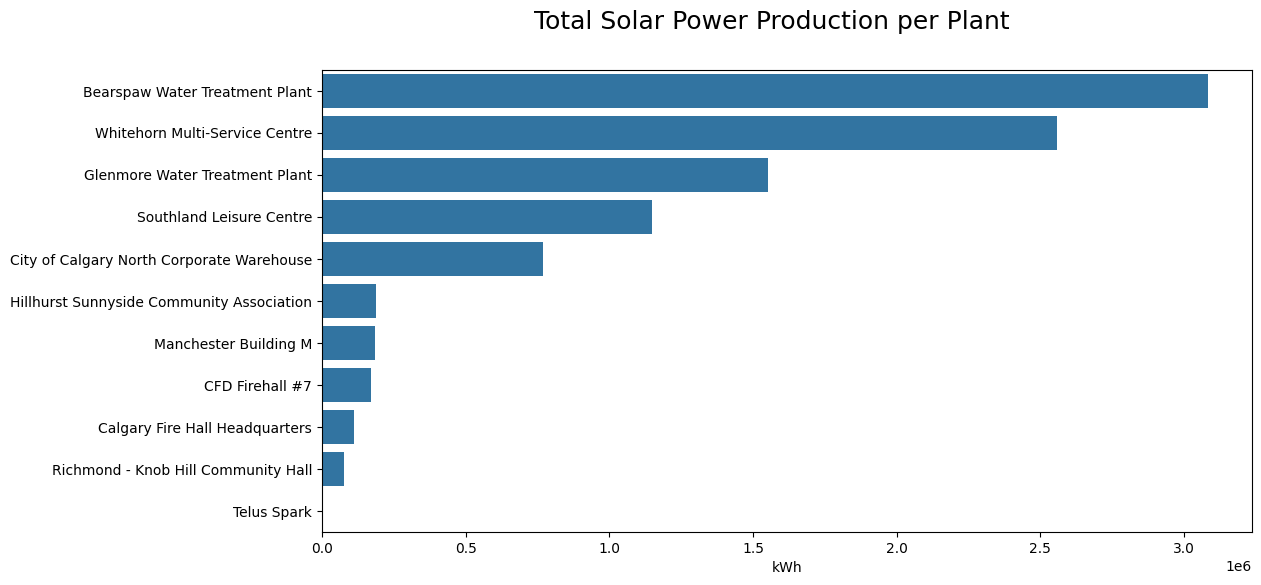

In [ ]:
totoal_plant_production = energy_production.groupby('name')[['kWh']].sum().sort_values('kWh', ascending=False).reset_index()

fig, ax = plt.subplots(figsize = (12,6))
sns.barplot(totoal_plant_production, x='kWh', y='name')
ax.set(ylabel=None)

fig.suptitle('Total Solar Power Production per Plant', fontsize=18)
fig.show()

<h2 style="font-family:courier;"> 2.2 Seasonality Pattern </h2>

In [ ]:
# Data for Monthly Heatmap per Plant
total_monthly_energy = (energy_production
              .loc[:, ['date', 'name','kWh']]
              .set_index('date')
              .groupby('name').resample('M').sum(numeric_only=True).reset_index().set_index('date')
              .groupby('name').resample('M').asfreq().fillna(0).drop(columns='name').reset_index()
              .pivot_table(index='name', columns='date', values='kWh')
        )

total_monthly_energy = total_monthly_energy.div(total_monthly_energy.max(axis=1), axis=0)

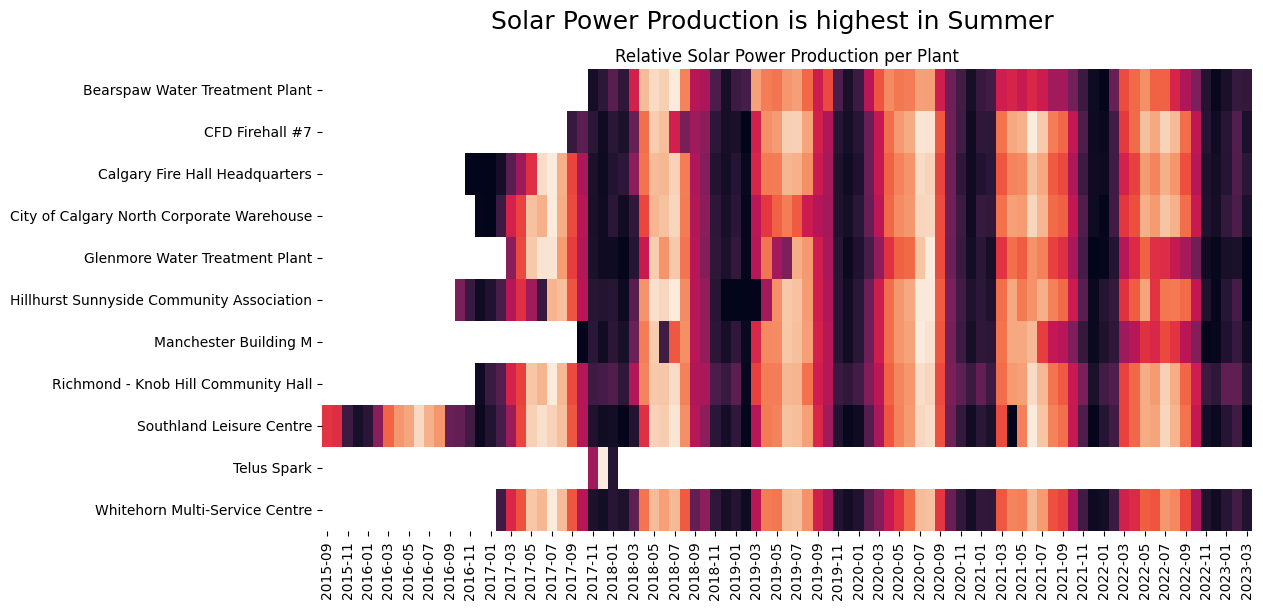

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))

sns.heatmap(total_monthly_energy, cbar=False)

x_dates = [x.get_text().replace('T00:00:00.000000000', '')[:-3] for x in ax.get_xticklabels()]
ax.set_xticklabels(labels=x_dates)
ax.set(xlabel=None)
ax.set(ylabel=None)

fig.suptitle('Solar Power Production is highest in Summer', fontsize=18)
plt.title('Relative Solar Power Production per Plant')

fig.show()


<h1 style="font-family:courier;"> III. Time Series Modelling </h1>   
<h2 style="font-family:courier;"> 3.1 Experiement Setup </h2>

<div style="font-family:courier; font-size:18px;">
For this experiment we limit us to a univariate time series modelling and choose the <b>Whitehorn Multi-Service Centre</b> power plant for modelling.
    
</div>

In [ ]:
## Experiment Setup
### Data Parameters
frequency = ['h', 'd', 'W', 'M'][2]
plant_name = "Whitehorn Multi-Service Centre"
forecast_horizon = 52
year_start = 2017
fh = list(range(1,forecast_horizon + 1))

regression_models = {
    'Lin_Reg': LinearRegression,
    'LGBM':LGBMRegressor
}

statistical_models = {
    'AutoARIMA': AutoARIMA,
    'AutoETS': AutoETS
}

## Evaluation
metrics = {
    'MAE': mean_absolute_error,
    'MSE': mean_squared_error
}

<h2 style="font-family:courier;"> 3.2 Data Preprocessing </h2>

In [ ]:
plant_data = (energy_production
              .loc[energy_production.name == plant_name, ['date', 'kWh']]
              .set_index('date')
              .resample(frequency).sum()
              .resample(frequency).asfreq().fillna(0)
        )

plant_data.head()

,kWh
date,
2017-02-19,5224.513
2017-02-26,4250.596
2017-03-05,10467.816
2017-03-12,1188.923
2017-03-19,10532.219


<h2 style="font-family:courier;"> 3.3 Check for Seasonality </h2>
+ Data has a yearly seasonality

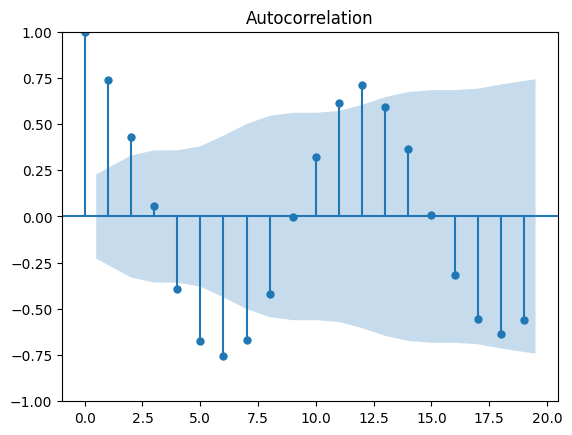

In [ ]:
plot_acf(plant_data.resample("M").sum())
plt.show()

<h2 style="font-family:courier;"> 3.4 Train Test Split </h2>

+ 1 year of weekly data for models comparison

In [ ]:
series_data = plant_data.loc[plant_data.index.year >= year_start].kWh

train, test = temporal_train_test_split(series_data, test_size=forecast_horizon)

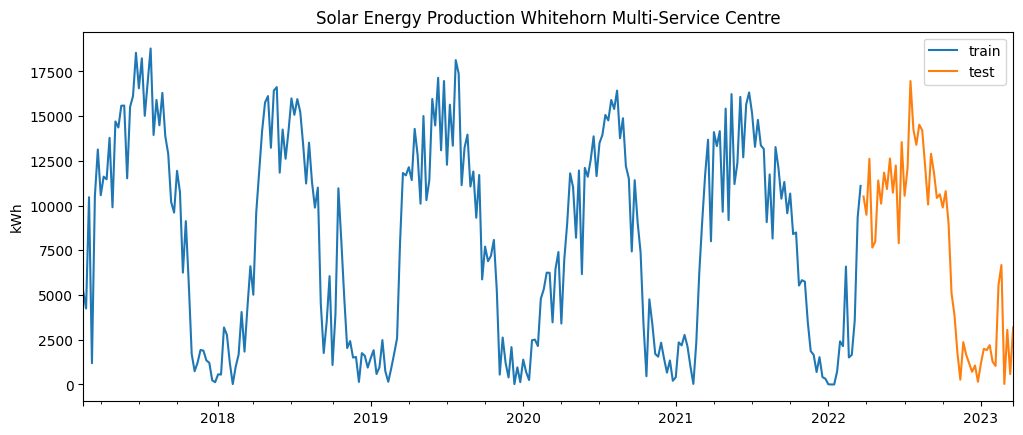

In [ ]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
plt.title('Solar Energy Production ' + plant_name)
ax.set(ylabel="kWh")
ax.set_xlabel('')
plt.legend();

<h2 style="font-family:courier;"> 3.5 Model Hyperparameter Tuning</h2>

<h3 style="font-family:courier;"> Create Validation Data Split</h3>

In [ ]:
train_opt, val_opt = temporal_train_test_split(train, test_size=forecast_horizon)

In [ ]:
def get_evaluation_results(predictions):
    models = [model_name for model_name in  hyperparameter_result.columns if model_name != 'y_true']

    metrics_frame = []
    for metric_name in metrics.keys():
        for model in models:
            metrics_frame.append(pd.DataFrame({
                'Metric': [metric_name],
                'Model': [model],
                'Score': [metrics[metric_name](hyperparameter_result['y_true'], hyperparameter_result[model])]
            }))

    metrics_frame = pd.concat(metrics_frame)

    return metrics_frame


<h3 style="font-family:courier;"> Linear Regression Hyperparameter Tuning</h3>

In [ ]:
### Modelling Parameters
model_name = 'Lin_Reg'
reg_model = regression_models[model_name]()

## Hyperparameter Ranges
lookback_windows = [12,24,52,105]
forecasting_approaches = ['direct', 'recursive', 'dirrec']

hyperparams_grid = [lookback_windows] + [forecasting_approaches]
hyperparams_grid = list(itertools.product(*hyperparams_grid))

hyperparameter_result = val_opt.to_frame().rename(columns={'kWh':'y_true'}).copy()

print(f"Evaluating {len(hyperparams_grid)} hyperparameter combinations")

for params in hyperparams_grid:
    lookback_window, approach = params

    forecaster = make_reduction(reg_model, window_length=lookback_window, strategy=approach)
    fit_kwargs = {} if approach == 'recursive' else {'fh':fh}

    # Fit and predict
    forecaster.fit(train_opt, **fit_kwargs)
    prediction = forecaster.predict(fh=fh)

    hyperparameter_result[approach + "_" + model_name + "_Window_" + str(lookback_window)] = prediction

hyperparameter_metrics =  get_evaluation_results(hyperparameter_result)
hyperparameter_metrics.sort_values('Score').groupby('Metric').head(1)

Evaluating 12 hyperparameter combinations


,Metric,Model,Score
0,MAE,direct_Lin_Reg_Window_24,2.081559e+03
0,MSE,dirrec_Lin_Reg_Window_24,5.945380e+06


**Best Model Parameters:**
+ 24 weeks lookback window
+ Direct Recursive Strategy

<h3 style="font-family:courier;"> Light GBM Hyperparameter Tuning</h3>

In [ ]:
### Modelling Parameters
model_name = 'LGBM'
reg_model = regression_models[model_name](seed=seed_value)
lookback_windows = [12,24,52]
forecasting_approaches = ['direct', 'recursive', 'dirrec']

hyperparams_grid = [lookback_windows] + [forecasting_approaches]
hyperparams_grid = list(itertools.product(*hyperparams_grid))

hyperparameter_result = val_opt.to_frame().rename(columns={'kWh':'y_true'}).copy()

print(f"{len(hyperparams_grid)} hyperparameter combinations")

for params in hyperparams_grid:
    lookback_window, approach = params

    forecaster = make_reduction(reg_model, window_length=lookback_window, strategy=approach)
    fit_kwargs = {} if approach == 'recursive' else {'fh':fh}

    # Fit and predict
    forecaster.fit(train_opt, **fit_kwargs)
    prediction = forecaster.predict(fh=fh)

    hyperparameter_result[approach + "_" + model_name + "_Window_" + str(lookback_window)] = prediction

hyperparameter_metrics =  get_evaluation_results(hyperparameter_result)
hyperparameter_metrics.sort_values('Score').groupby('Metric').head(1)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

Exception ignored on calling ctypes callback function: <function _log_callback at 0x789c17a8f250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 257, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Exception ignored on calling ctypes callback function: <function _log_callback at 0x789c17a8f250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 257, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

,Metric,Model,Score
0,MAE,recursive_LGBM_Window_52,1.671636e+03
0,MSE,recursive_LGBM_Window_52,4.642011e+06


**Best Model Parameters:**
+ 52 weeks lookback window
+ Recursive Strategy

<h2 style="font-family:courier;"> 3.7 Final Models Predictions</h2>

In [ ]:
# Use to save all Model Prediction
evaluation_frame = test.to_frame().rename(columns={'kWh':'y_true'}).copy()


In [ ]:
# 1. Linear Regression
window_size = 24
approach = 'dirrec'
model_name = 'Lin_Reg'
forecaster = make_reduction(regression_models[model_name](), window_length=window_size, strategy=approach)
fit_kwargs = {} if approach == 'recursive' else {'fh':fh}
print(f"Fitting {model_name}")
forecaster.fit(train, **fit_kwargs)
prediction = forecaster.predict(fh=fh)

evaluation_frame[model_name] = prediction


# 2. Light GBM
window_size = 52
approach = 'recursive'
model_name = 'LGBM'
forecaster = make_reduction(regression_models[model_name](seed=seed_value), window_length=window_size, strategy=approach)
fit_kwargs = {} if approach == 'recursive' else {'fh':fh}
print(f"Fitting {model_name}")
forecaster.fit(train, **fit_kwargs)
prediction = forecaster.predict(fh=fh)

evaluation_frame[model_name] = prediction


Fitting Lin_Reg
Fitting LGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3786
[LightGBM] [Info] Number of data points in the train set: 214, number of used features: 52
[LightGBM] [Info] Start training from score 7895.294553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

<h2 style="font-family:courier;"> ARIMA & ETS</h2>

In [ ]:
for model_name in statistical_models.keys():
    forecaster = statistical_models[model_name]()
    print(f"Fitting {model_name}")
    forecaster.fit(train)
    prediction = forecaster.predict(fh=fh)

    evaluation_frame[model_name] = prediction

Fitting AutoARIMA
Fitting AutoETS


<h1 style="font-family:courier;"> IV. Models Comparison </h1>   


In [ ]:

plot_df = evaluation_frame.reset_index().melt(id_vars='date').rename(columns={'value':'kWh'})
plot_df = pd.concat([train.reset_index().assign(variable="y_true"), plot_df])

px.line(plot_df, x='date', y='kWh', color='variable', title="Model Predictions vs. True Value")

<h2 style="font-family:courier;"> 4.1 Mean Absolute Error </h2>   


In [ ]:
models = [model_name for model_name in  evaluation_frame.columns if model_name != 'y_true']

metrics_frame = []
for metric_name in metrics.keys():
    for model in models:

        metrics_frame.append(pd.DataFrame({
            'Metric': [metric_name],
            'Model': [model],
            'Score': [metrics[metric_name](evaluation_frame['y_true'], evaluation_frame[model])]
        }))

metrics_frame = pd.concat(metrics_frame)

In [ ]:
metric = 'MAE'
px.bar(metrics_frame.loc[metrics_frame.Metric == metric], x='Model', color='Model', y='Score')

<h2 style="font-family:courier;"> 4.2 Mean Squared Error </h2>   

In [ ]:
metric = 'MSE'
px.bar(metrics_frame.loc[metrics_frame.Metric == metric], x='Model', color='Model', y='Score')